In [41]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import itertools
%matplotlib inline

In [10]:
def load_imgs(path):
    return [mpimg.imread(e) for e in glob.glob(path)]

vehicle_imgs = load_imgs('train_images/vehicles/*/*.png')
non_vehicle_imgs = load_imgs('train_images/non-vehicles/*/*.png')

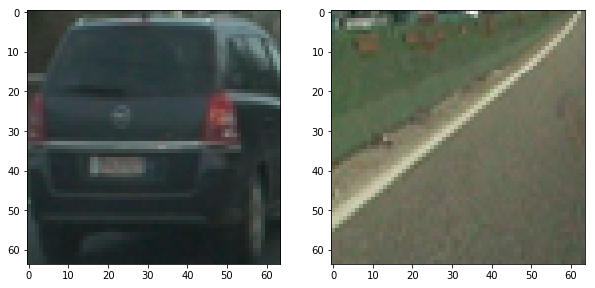

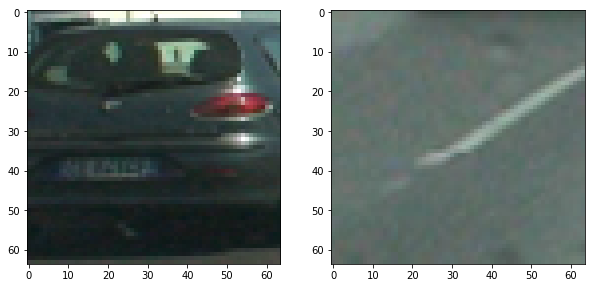

In [65]:
def show_img_lists(img_lists):
    for i in range(len(img_lists[0])):
        fig, axs = plt.subplots(1, len(img_lists), figsize=(10, 5))
        
        for ax, img_list in zip(axs, img_lists):
            img = img_list[i]
            
            title = ''
            if isinstance(img, tuple):
                img, title = img
                
            cmap = 'gray' if len(img.shape) == 2 else None
            ax.imshow(img, cmap=cmap)
            ax.set_title(title)

show_img_lists((vehicle_imgs[:2], non_vehicle_imgs[:2]))

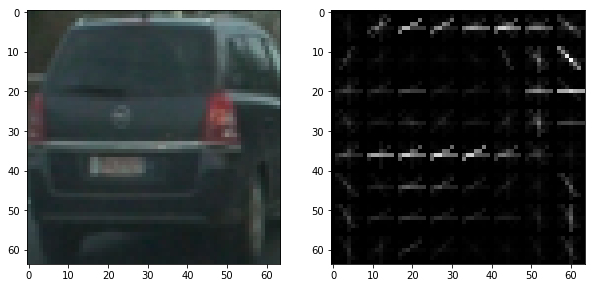

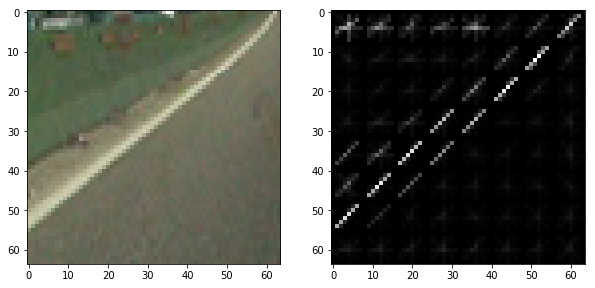

In [74]:
def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, visualise=False):
    return hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=True)

sample_imgs = [vehicle_imgs[0], non_vehicle_imgs[0]]
sample_hog_imgs = [get_hog_features(img[:,:,2], visualise=True)[1] for img in sample_imgs]
show_img_lists((sample_imgs, sample_hog_imgs))

## Visualizing color spaces and channels with HOG features

* RGB and HSV show most distinction between vehicle and non-vehicle
* RGB channels seem to be redundant
* HSV channels show distinct features

**Conclusion: Use HSV**

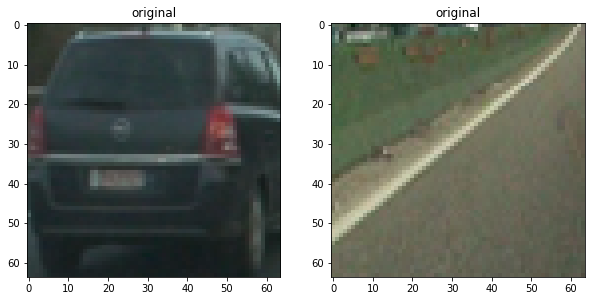

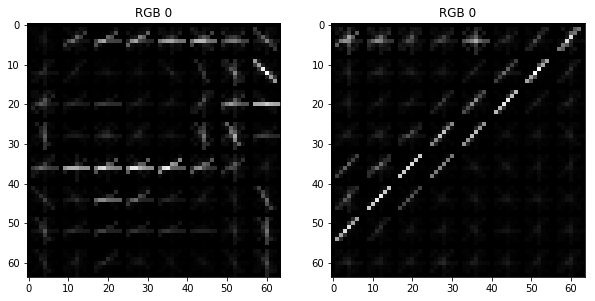

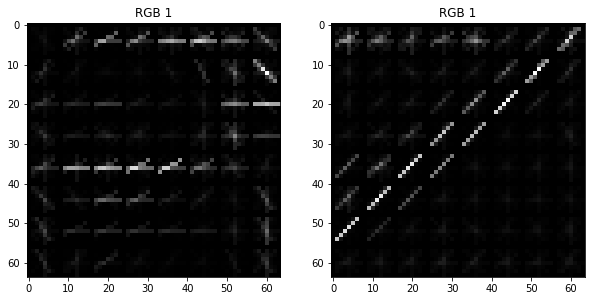

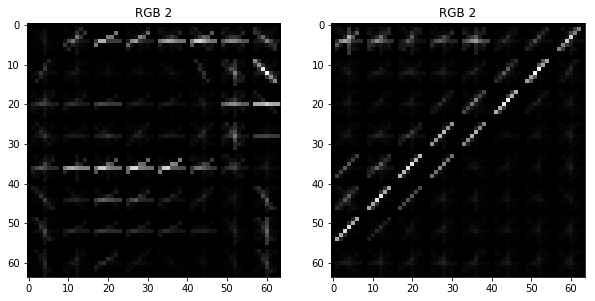

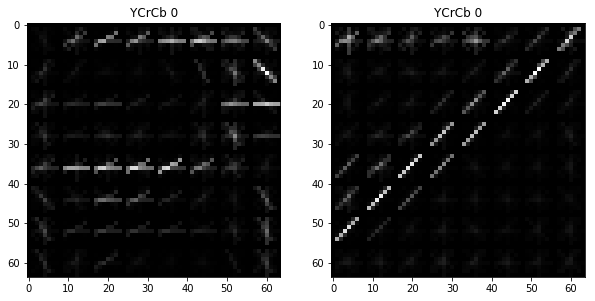

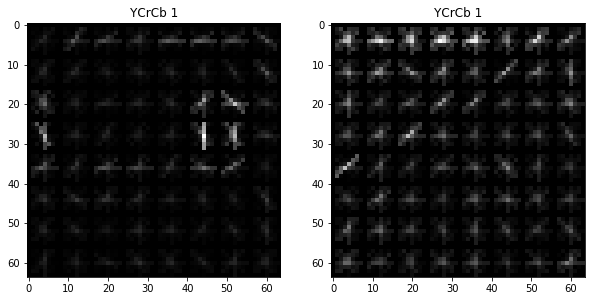

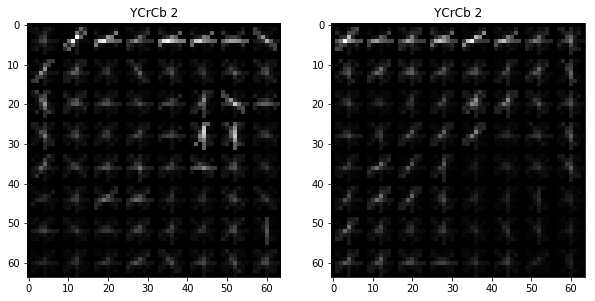

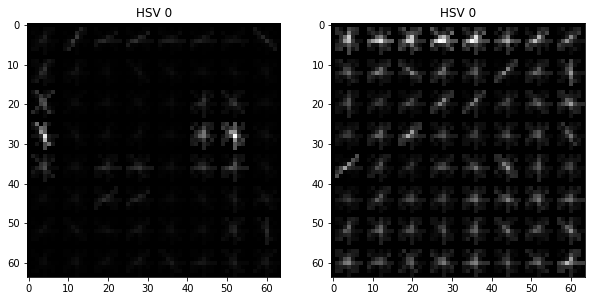

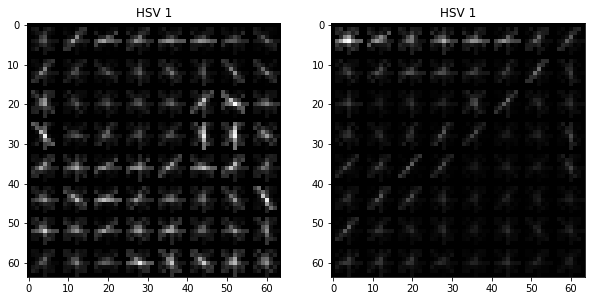

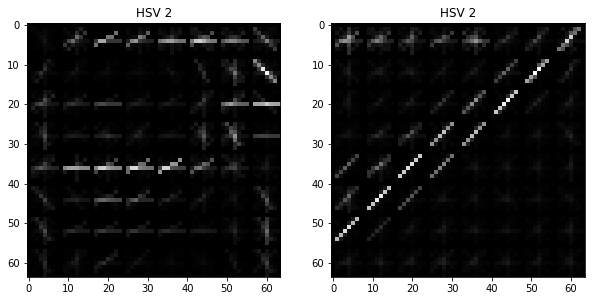

In [76]:
sample_imgs = [vehicle_imgs[0], non_vehicle_imgs[0]]
spaces = [(None, 'RGB'), (cv2.COLOR_RGB2YCrCb, 'YCrCb'), (cv2.COLOR_RGB2HSV, 'HSV')]
channels = [(0, '0'), (1, '1'), (2, '2')]
output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for space, channel in itertools.product(spaces, channels):
        space_img = img if space[0] is None else cv2.cvtColor(img, space[0])
        channel_img = space_img[:,:,channel[0]]
        hog_img = get_hog_features(channel_img, visualise=True)[1]
        output_imgs.append((hog_img, '{} {}'.format(space[1], channel[1])))
    
    output_img_lists.append(output_imgs)
    
show_img_lists(output_img_lists)

## Visualizing HOG parameters

- 8 orientations look a little bit cleaner
- 4 pixels per cell is too details
- not much difference for cells per block

**Conclusion: Use 8 orientations, 8 pixels per cell and 2 cells per block**

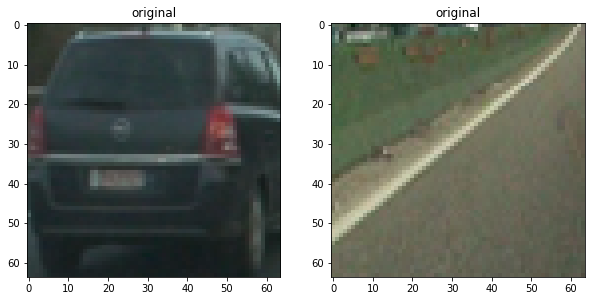

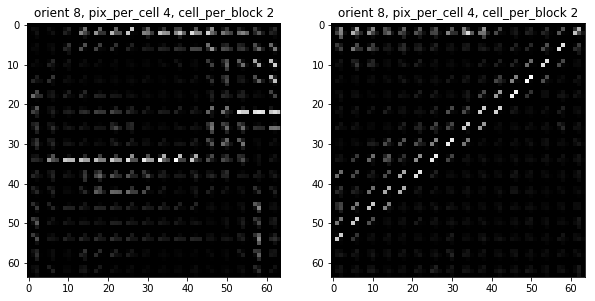

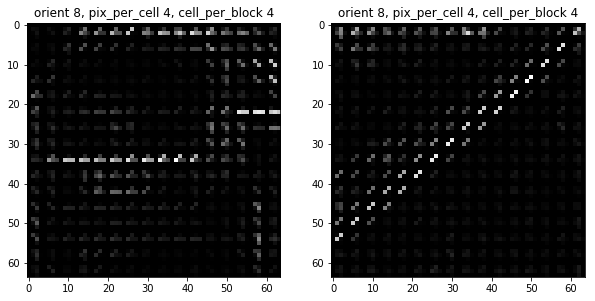

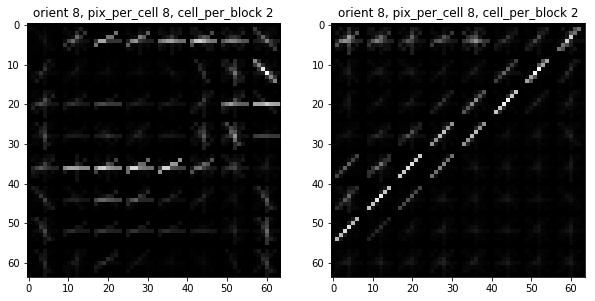

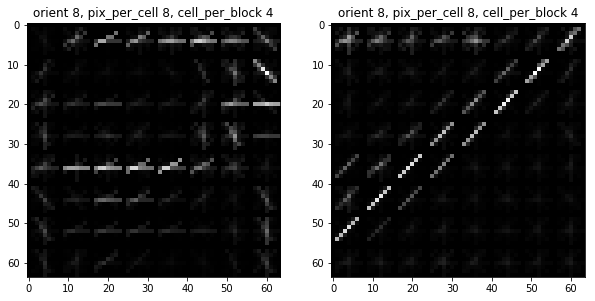

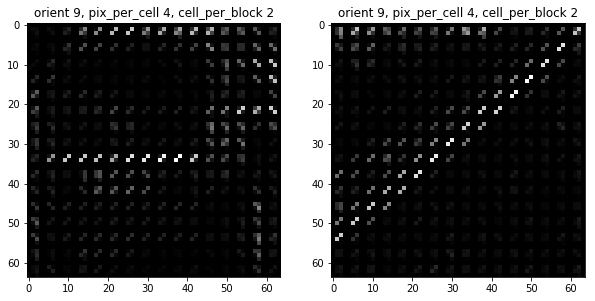

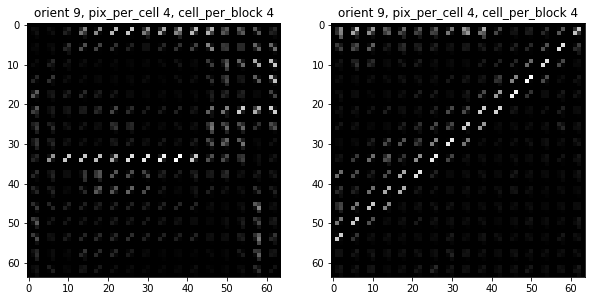

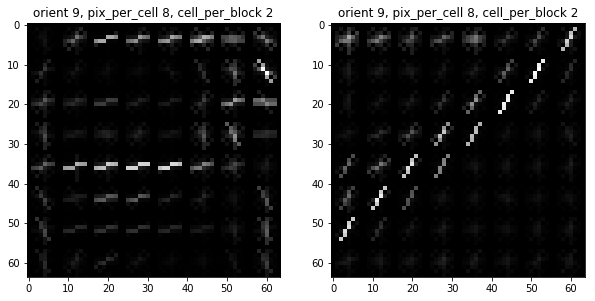

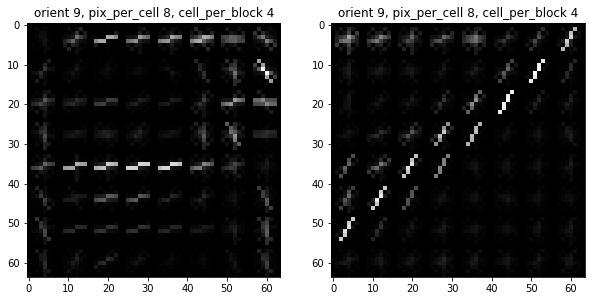

In [77]:
orient_list = [8, 9]
pix_per_cell_list = [4, 8]
cell_per_block_list = [2, 4]

output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for orient, pix_per_cell, cell_per_block  in itertools.product(orient_list, pix_per_cell_list, cell_per_block_list):
        space_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        channel_img = space_img[:,:,2]
        hog_img = get_hog_features(channel_img, orient, pix_per_cell, cell_per_block, visualise=True)[1]
        output_imgs.append((hog_img, 'orient {}, pix_per_cell {}, cell_per_block {}'
                            .format(orient, pix_per_cell, cell_per_block)))
    
    output_img_lists.append(output_imgs)
    
show_img_lists(output_img_lists)

In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)